### Halliburton Internship - A data quality project 
### Project report submitted by: Nidhi Mankala

In [1]:
import pyodbc
import pandas as pd

In [2]:
# Trusted Connection to Named Instance
connection = pyodbc.connect('DRIVER={SQL Server Native Client 11.0};SERVER=localhost\SQLEXPRESS;DATABASE=test;Trusted_Connection=yes;')

In [3]:
cursor=connection.cursor()
cursor.execute("SELECT @@VERSION as version")

In [4]:
cursor.execute('SELECT TOP(10) * FROM [test].[dbo].[field]')


In [5]:
for row in cursor:
    print(row)

('Field', 'RA', datetime.date(2021, 10, 16), Decimal('151644'))
('Field', 'SA', datetime.date(2021, 10, 16), Decimal('85424'))
('Field', 'Undefined', datetime.date(2021, 10, 16), Decimal('8355'))
('Field', 'AD', datetime.date(2021, 10, 15), Decimal('6783'))
('Field', 'RA', datetime.date(2021, 10, 15), Decimal('136145'))
('Field', 'RQ', datetime.date(2021, 10, 15), Decimal('9188'))
('Field', 'SA', datetime.date(2021, 10, 15), Decimal('93898'))
('Field', 'AD', datetime.date(2021, 10, 14), Decimal('6775'))
('Field', 'RA', datetime.date(2021, 10, 14), Decimal('135826'))
('Field', 'RQ', datetime.date(2021, 10, 14), Decimal('9108'))


In [6]:
data = pd.read_sql('SELECT * FROM [test].[dbo].[field]', connection)

In [7]:
data

,LevelType,LevelName,Date,DCP
0,Field,RA,2021-10-16,151644.0
1,Field,SA,2021-10-16,85424.0
2,Field,Undefined,2021-10-16,8355.0
3,Field,AD,2021-10-15,6783.0
4,Field,RA,2021-10-15,136145.0
...,...,...,...,...
21183,GC,GC120,2016-01-01,27168.0
21184,GC,GC23,2016-01-01,33047.0
21185,GC,GC15,2016-01-01,107523.0
21186,GC,GC25,2016-01-01,85614.0


# DATA PRE PROCESSING 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

<AxesSubplot:>

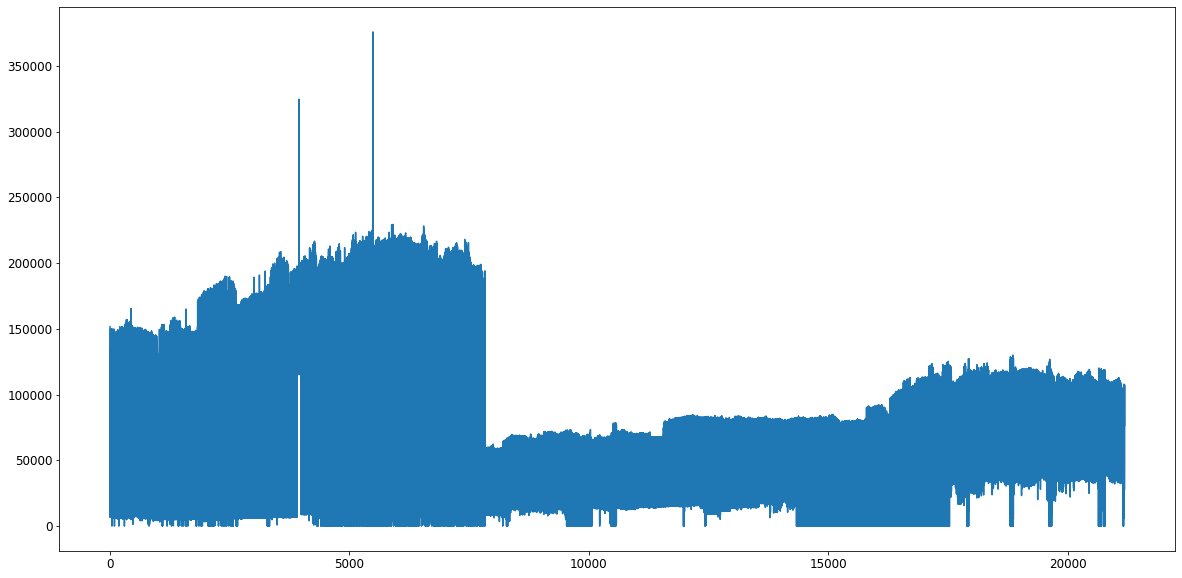

In [9]:
data['DCP'].plot(figsize=(20,10))

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21188 entries, 0 to 21187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LevelType  21188 non-null  object 
 1   LevelName  21188 non-null  object 
 2   Date       21188 non-null  object 
 3   DCP        21188 non-null  float64
dtypes: float64(1), object(3)
memory usage: 662.2+ KB


In [11]:
data.index.inferred_type == "datetime64"


False

In [12]:
data=data.sort_values('Date', ascending=True)

In [13]:
data.isna().sum()

LevelType    0
LevelName    0
Date         0
DCP          0
dtype: int64

In [14]:
df=data.dropna()

In [15]:
df.head()

,LevelType,LevelName,Date,DCP
21187,GC,GC24,2016-01-01,76515.0
7830,Field,SA,2016-01-01,130568.0
7829,Field,RA,2016-01-01,194039.0
21186,GC,GC25,2016-01-01,85614.0
7828,Field,AD,2016-01-01,5261.0


In [16]:
df[df.DCP == 0.0]

,LevelType,LevelName,Date,DCP
7827,Field,Undefined,2016-01-02,0.0
21166,GC,GC23,2016-01-05,0.0
21158,GC,GC23,2016-01-06,0.0
7674,Field,Undefined,2016-02-07,0.0
20776,GC,GC120,2016-03-23,0.0
...,...,...,...,...
8278,GC,GC120,2021-08-15,0.0
185,Field,Undefined,2021-08-23,0.0
8201,GC,GC31,2021-08-25,0.0
92,Field,Undefined,2021-09-20,0.0


#df=df.iloc[500: , :]
df=df[df['Date'] >= '2016-01-01']

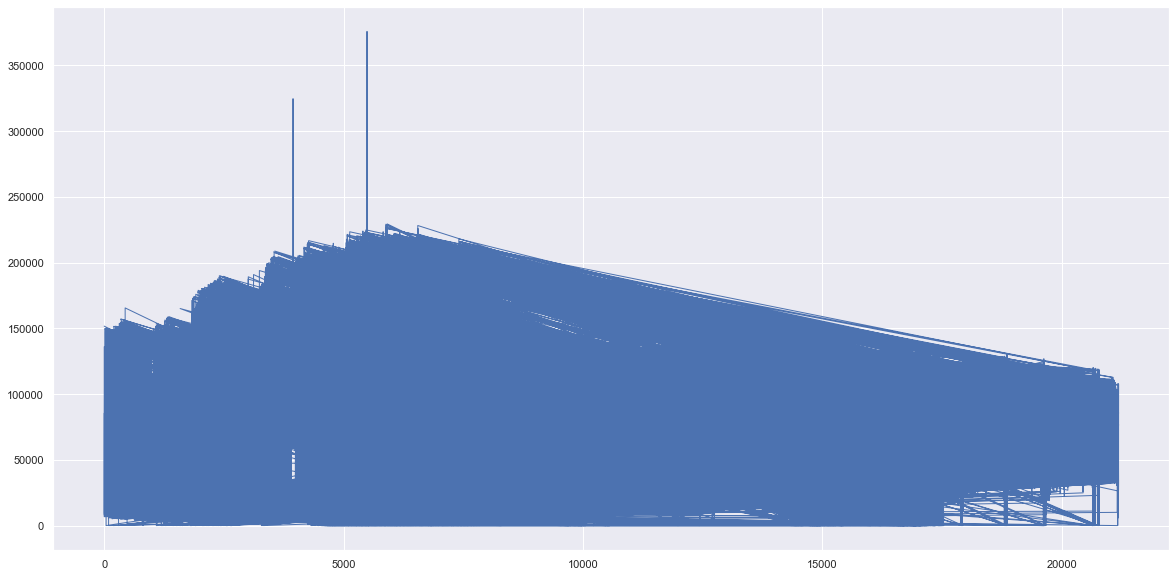

In [17]:
sns.set(rc={'figure.figsize':(20, 10)})
df['DCP'].plot(linewidth=1);


# 'GC' Level Daily
Filter to 'GC'
Aggregate DCP to daily level
Find if there are missing days

In [18]:
# TODO: read about why to use copy()
cleanDF = df[df['DCP'] > 0].copy()

<AxesSubplot:xlabel='Date'>

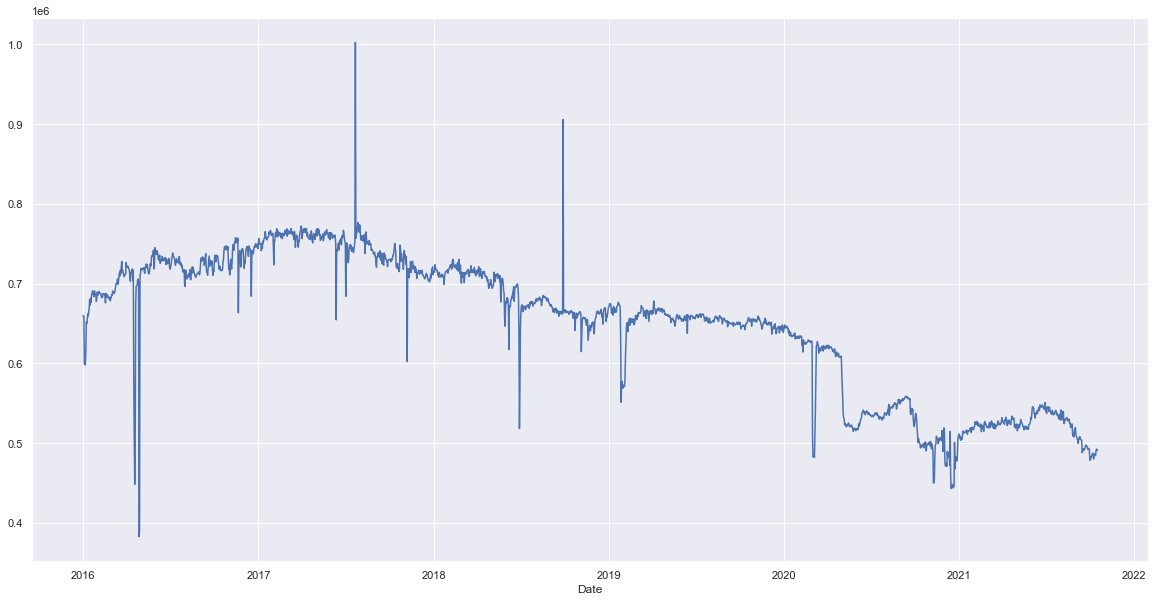

In [19]:
df.groupby('Date')['DCP'].sum().plot()

In [20]:
df2 = df[df['LevelType'] == 'GC'].groupby('Date').agg({'LevelName':'nunique'}).reset_index().rename(columns={'LevelName':'Unique'})

In [21]:
df3 = df[df['LevelType'] == 'GC'].groupby('Date').agg({'LevelName':'count'}).reset_index().rename(columns={'LevelName':'Count'})

In [22]:
combDF = pd.merge(df2,df3,on=['Date'],how='outer')

In [23]:
combDF[combDF['Unique'] != combDF['Count']]

,Date,Unique,Count


In [24]:
df4= df[df['LevelType'] == 'GC'].groupby('Date').sum()

In [25]:
df4.head()

,DCP
Date,
2016-01-01,329867.0
2016-01-02,329494.0
2016-01-03,329681.0
2016-01-04,299821.0
2016-01-05,299117.0


In [26]:
df4=df4.reset_index()

In [27]:
df4['Date'].nunique()

2116

In [28]:
df4['Date'] = pd.to_datetime(df4['Date'])

In [29]:
df4=df4.set_index('Date')

In [30]:
print(pd.date_range(
  start="2016-01-01", end="2021-10-09").difference(df4.index))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


ALL dates starting from 2016-01-01 are included

# 'Field' Level Daily
Filter to 'Field'
Aggregate DCP to daily level
Find if there are missing days

In [31]:
df5 = df[df['LevelType'] == 'Field'].groupby('Date').agg({'LevelName':'nunique'}).reset_index().rename(columns={'LevelName':'Unique'})

In [32]:
df6 = df[df['LevelType'] == 'Field'].groupby('Date').agg({'LevelName':'count'}).reset_index().rename(columns={'LevelName':'Count'})

In [33]:
combDF = pd.merge(df5,df6,on=['Date'],how='outer')

In [34]:
combDF[combDF['Unique'] != combDF['Count']]

,Date,Unique,Count


In [35]:
df7= df[df['LevelType'] == 'Field'].groupby('Date').sum()

<AxesSubplot:xlabel='Date'>

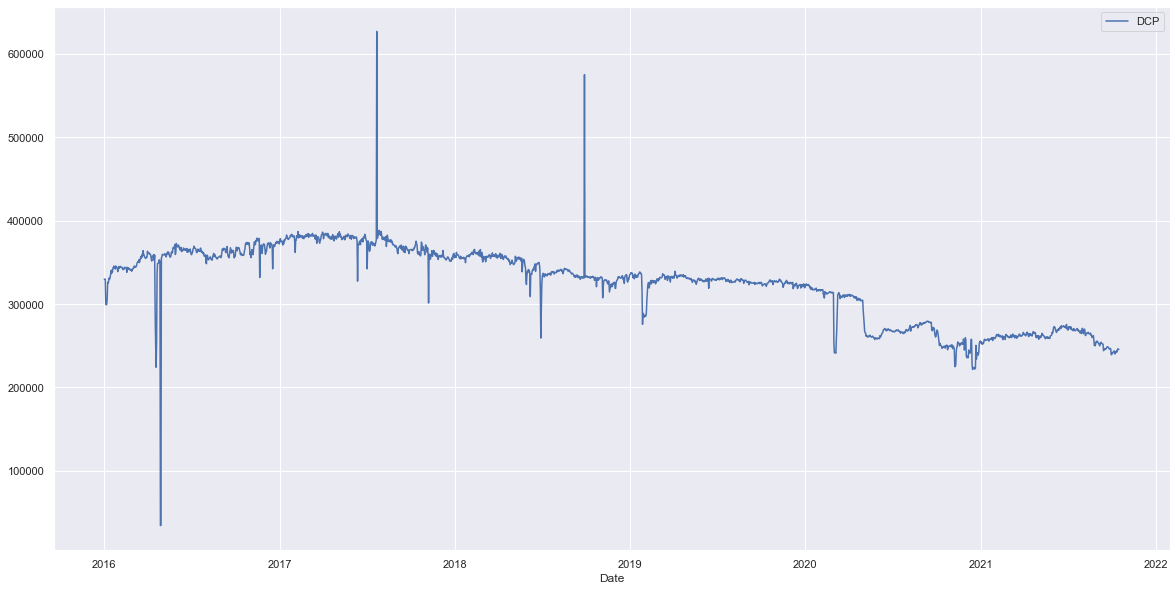

In [36]:
df7.plot()

In [37]:
df7=df7.reset_index()

In [38]:
df7['Date'].nunique()

2116

In [39]:
df7=df7.set_index('Date')

In [40]:
print(pd.date_range(
  start="2016-01-01", end="2021-10-09").difference(df7.index))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


# STATIONARY TEST

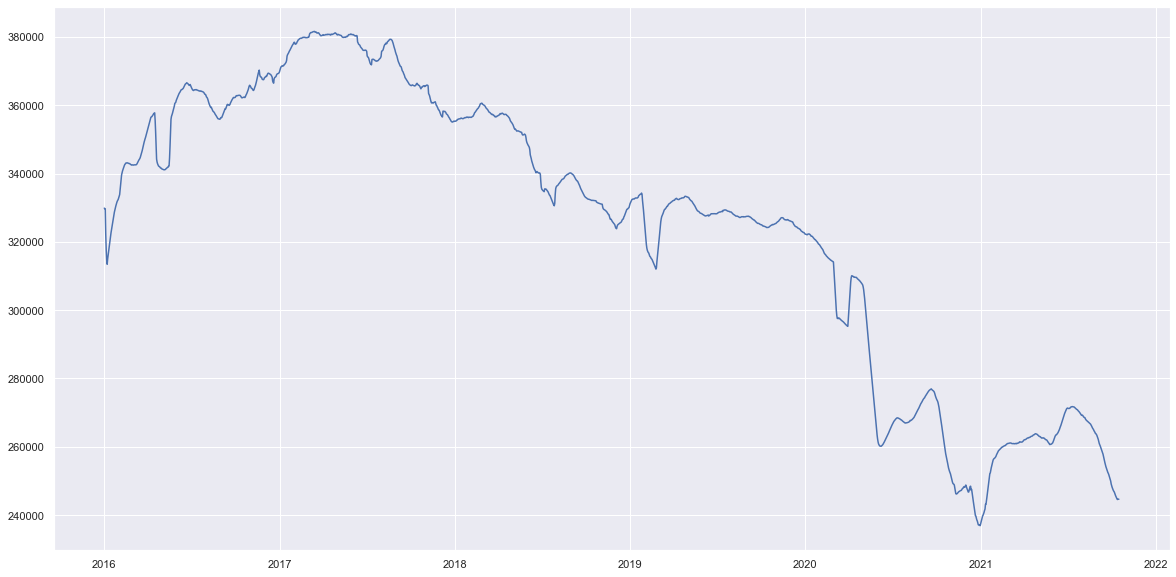

In [41]:
plt.plot(df4.rolling(window='30D').mean())
plt.show()


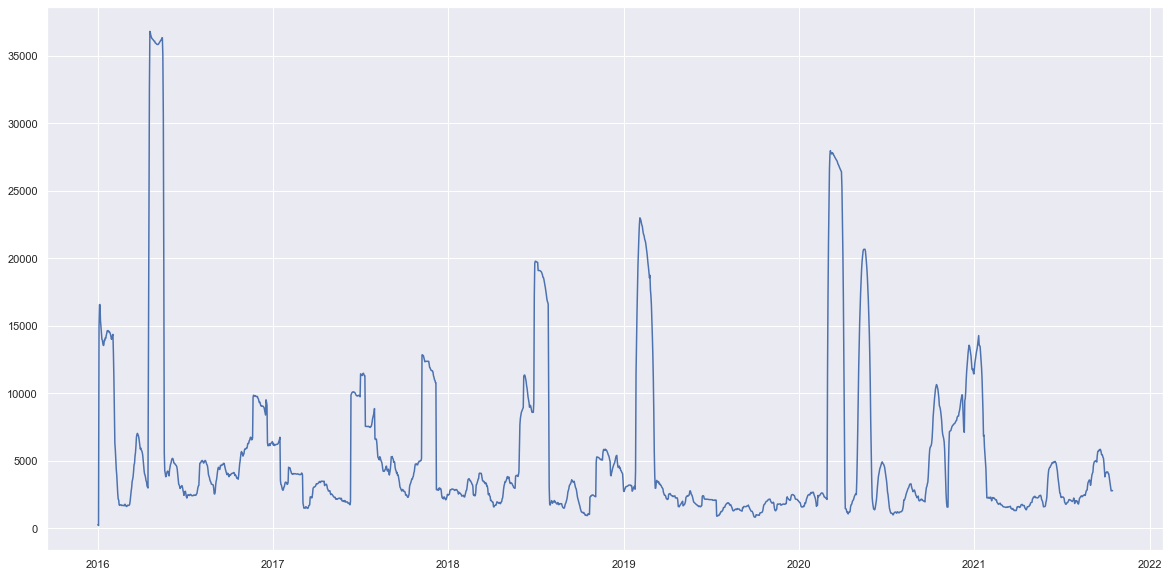

In [42]:
plt.plot(df4.rolling(window='30D').std())
plt.show()

In [43]:
#Augmented Dickey-fuller test

In [44]:
#reject the null hypothesis (that the series is stationary)

In [45]:
from statsmodels.tsa.stattools import adfuller


In [46]:
print("Observations of Dickey-fuller test")
dftest = adfuller(df4,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                   -0.221899
p-value                           0.935861
#lags used                       21.000000
number of observations used    2094.000000
critical value (1%)              -3.433477
critical value (5%)              -2.862921
critical value (10%)             -2.567505
dtype: float64


In [47]:
#ADF
##p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the s0eries is stationary
##test statistics has to be less than the critical value

In [48]:
#stationary test around mean
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [49]:
kpss_test(df4)

Results of KPSS Test:
Test Statistic            6.317527
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\hpp\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [50]:
#KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
#if p-value is < signif level (say 0.05), then the series is non-stationary
#the test may not necessarily reject the null hypothesis (that the series is stationary) even if a series is steadily increasing or decreasing.

In [51]:
#stationarity of the series around a ‘deterministic trend’.
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    
kpss_test(df4, regression='ct')

KPSS Statistic: 0.9925455741081595
p-value: 0.01
num lags: 28
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is not stationary


C:\Users\hpp\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# Results

## ADF TEST:  NOT STATIONARY
## KPSS TEST: NOT STATIONARY

In [52]:
#Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. 
#Differencing is to be used to make series stationary. 
#The differenced series is checked for stationarity.

In [53]:
#df4["diff"] = df4["DCP"] - df4["DCP"].shift(1)


In [54]:
#df4["diff"].dropna().plot(figsize=(12, 8))

In [55]:
#plt.plot(df4['diff'].rolling(window='30D').mean())
#plt.show()

In [56]:
#plt.plot(df4['diff'].rolling(window='30D').std())
#plt.show()

In [57]:
df4=df4.reset_index()

In [58]:
y = df4.set_index('Date')

In [59]:
y.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2021-10-07', '2021-10-08', '2021-10-09', '2021-10-10',
               '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
               '2021-10-15', '2021-10-16'],
              dtype='datetime64[ns]', name='Date', length=2116, freq=None)

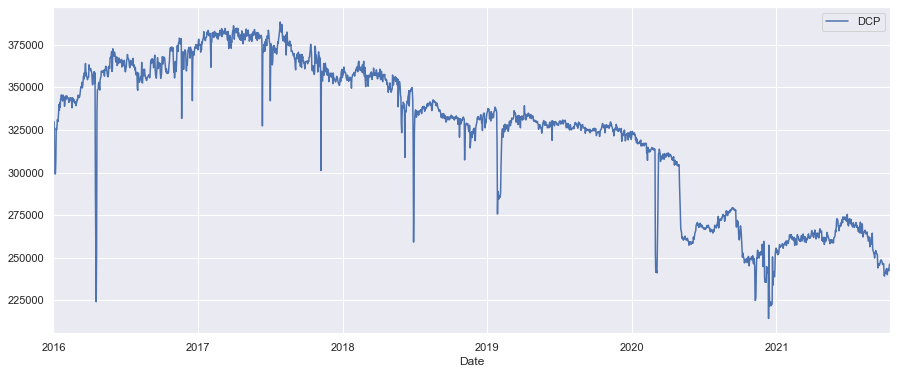

In [60]:
y.plot(figsize=(15, 6))
plt.show()

In [61]:
import statsmodels.api as sm

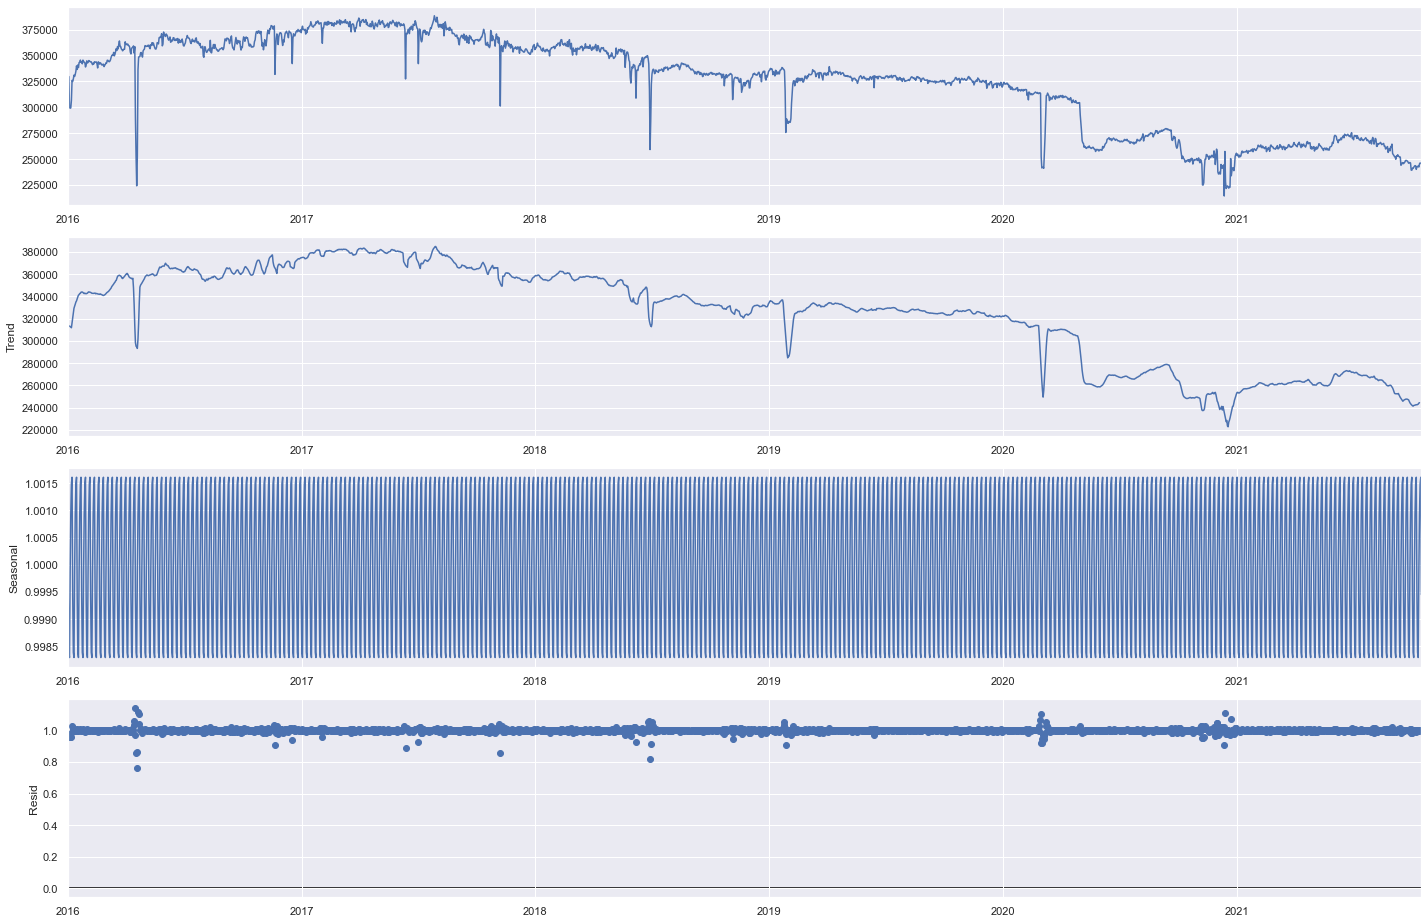

In [62]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 13
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()train_x,train_y,test_x,test_y = train_test_builder(df)


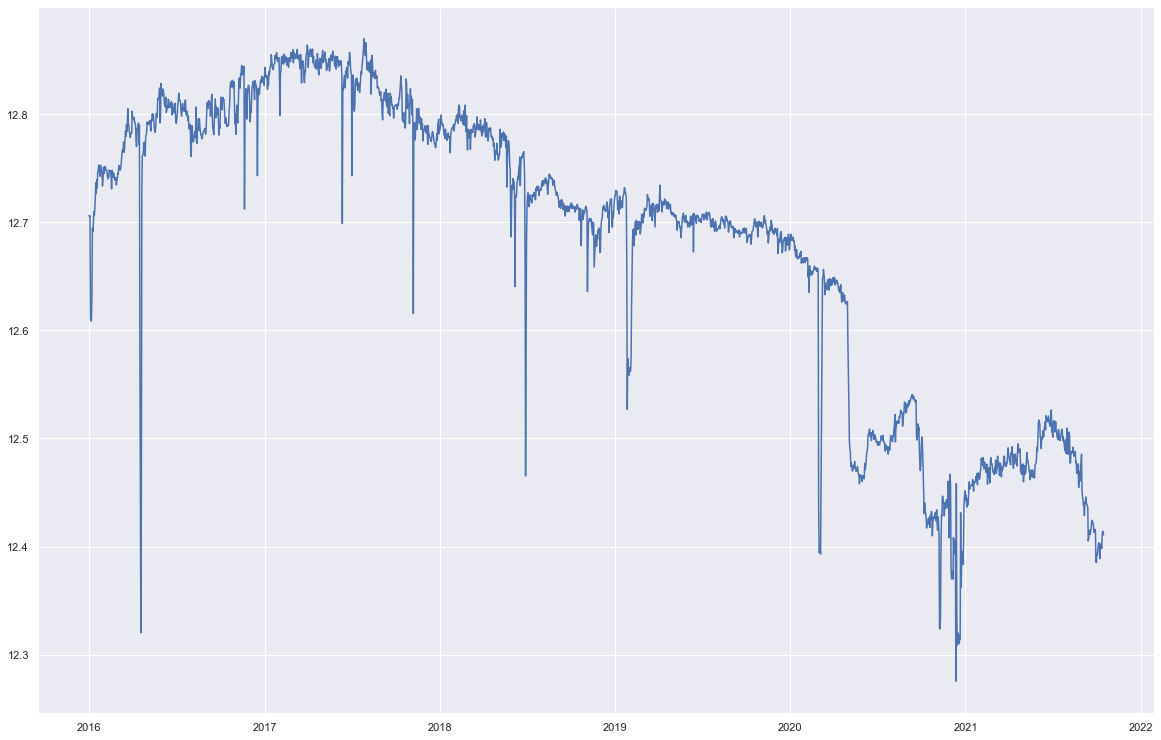

In [63]:
import numpy as np

ts_log = np.log(y)
plt.plot(ts_log)

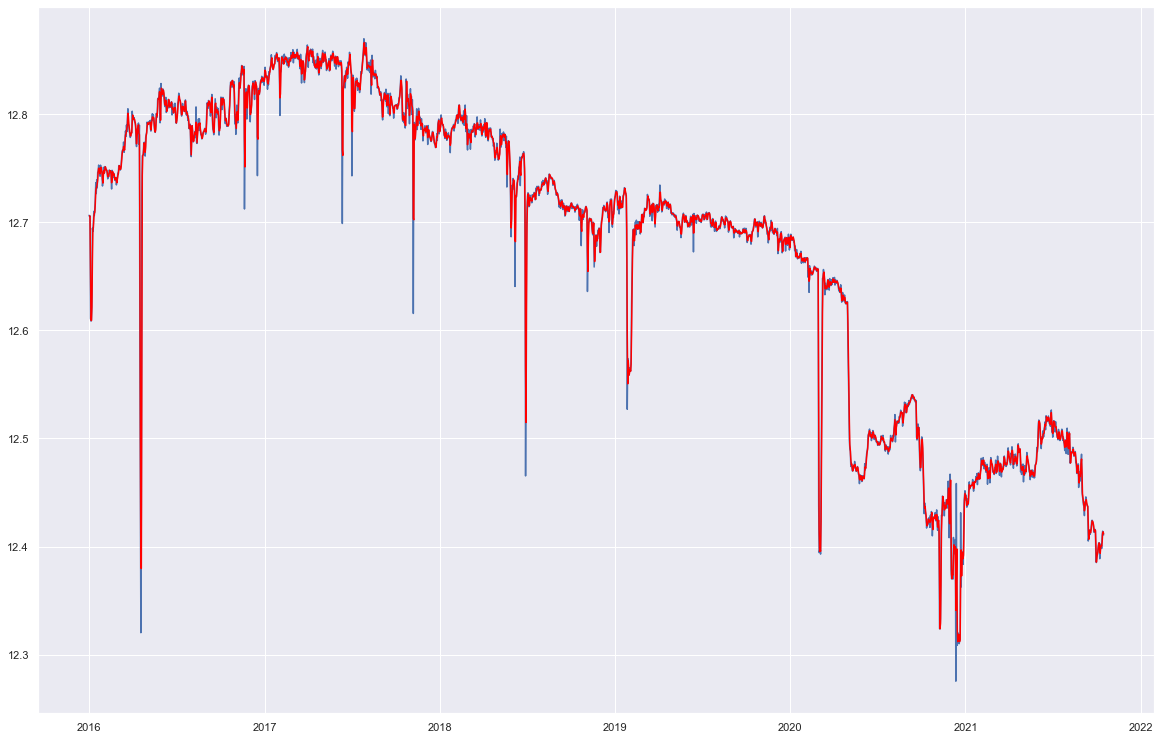

In [64]:
moving_avg = ts_log.rolling(2).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [65]:
ts_log_moving_avg_diff = ts_log.DCP - moving_avg.DCP
ts_log_moving_avg_diff.head(30)

Date
2016-01-01         NaN
2016-01-02   -0.000566
2016-01-03    0.000284
2016-01-04   -0.047470
2016-01-05   -0.001175
2016-01-06    0.000475
2016-01-07    0.012011
2016-01-08    0.030460
2016-01-09   -0.001516
2016-01-10    0.003647
2016-01-11    0.005640
2016-01-12   -0.001898
2016-01-13    0.003026
2016-01-14    0.004577
2016-01-15    0.007595
2016-01-16   -0.005072
2016-01-17    0.006414
2016-01-18   -0.003760
2016-01-19    0.007152
2016-01-20    0.000466
2016-01-21    0.002945
2016-01-22   -0.003052
2016-01-23    0.000093
2016-01-24   -0.002229
2016-01-25    0.005143
2016-01-26   -0.001982
2016-01-27   -0.000794
2016-01-28   -0.000880
2016-01-29   -0.006008
2016-01-30    0.002713
Name: DCP, dtype: float64

<AxesSubplot:xlabel='Date'>

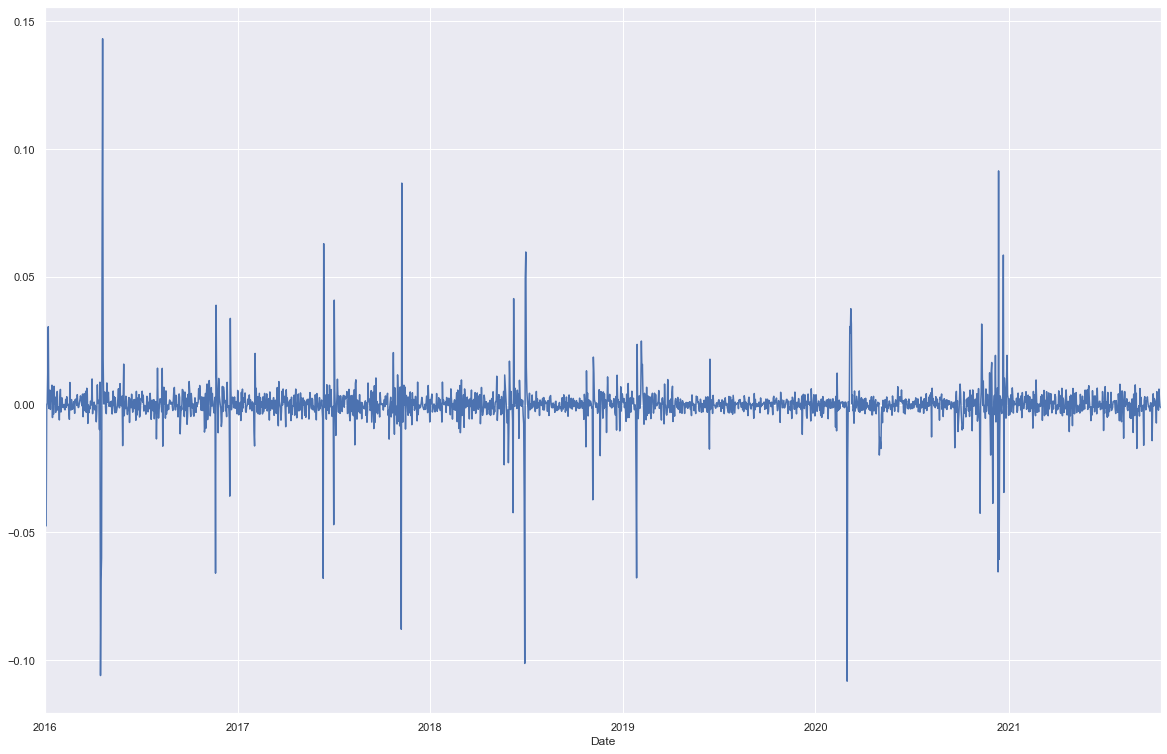

In [66]:
ts_log_moving_avg_diff.plot()

In [67]:
ts_log_moving_avg_diff.dropna(inplace=True)


In [68]:
print("Observations of Dickey-fuller test")
dftest = adfuller(ts_log_moving_avg_diff,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                -1.387570e+01
p-value                        6.344705e-26
#lags used                     2.000000e+01
number of observations used    2.094000e+03
critical value (1%)           -3.433477e+00
critical value (5%)           -2.862921e+00
critical value (10%)          -2.567505e+00
dtype: float64


# ADF TEST : PASS

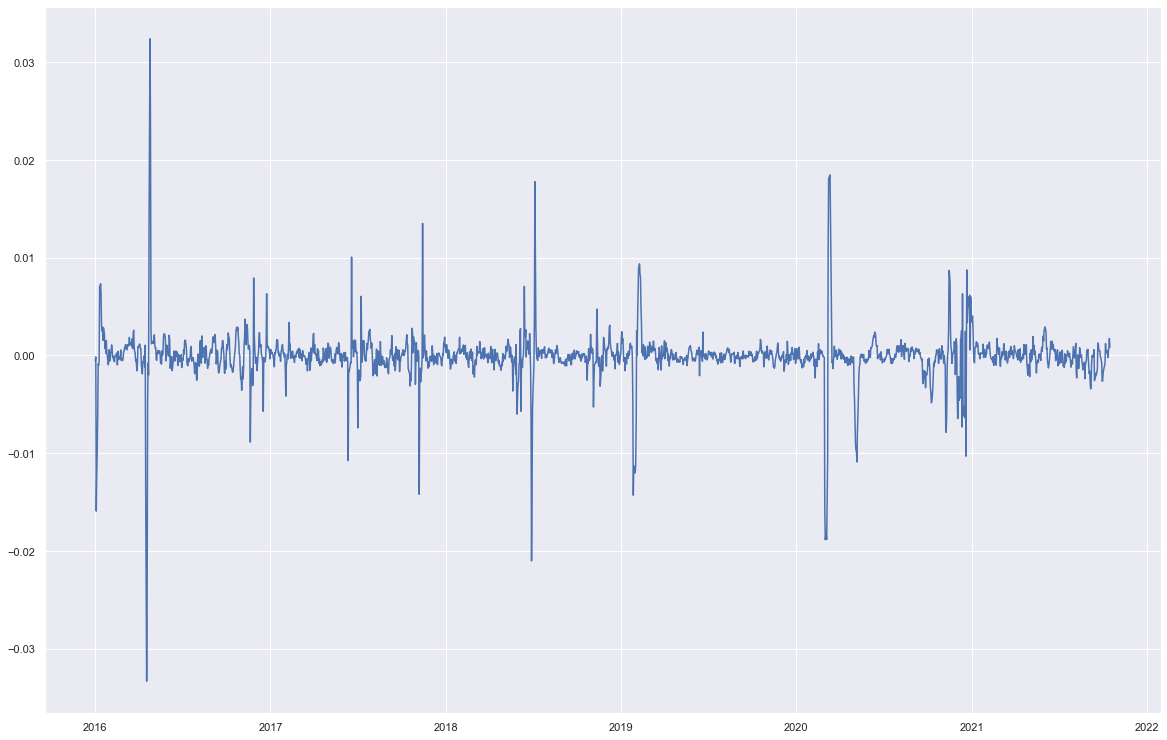

In [69]:
plt.plot(ts_log_moving_avg_diff.rolling(window='7D').mean())
plt.show()


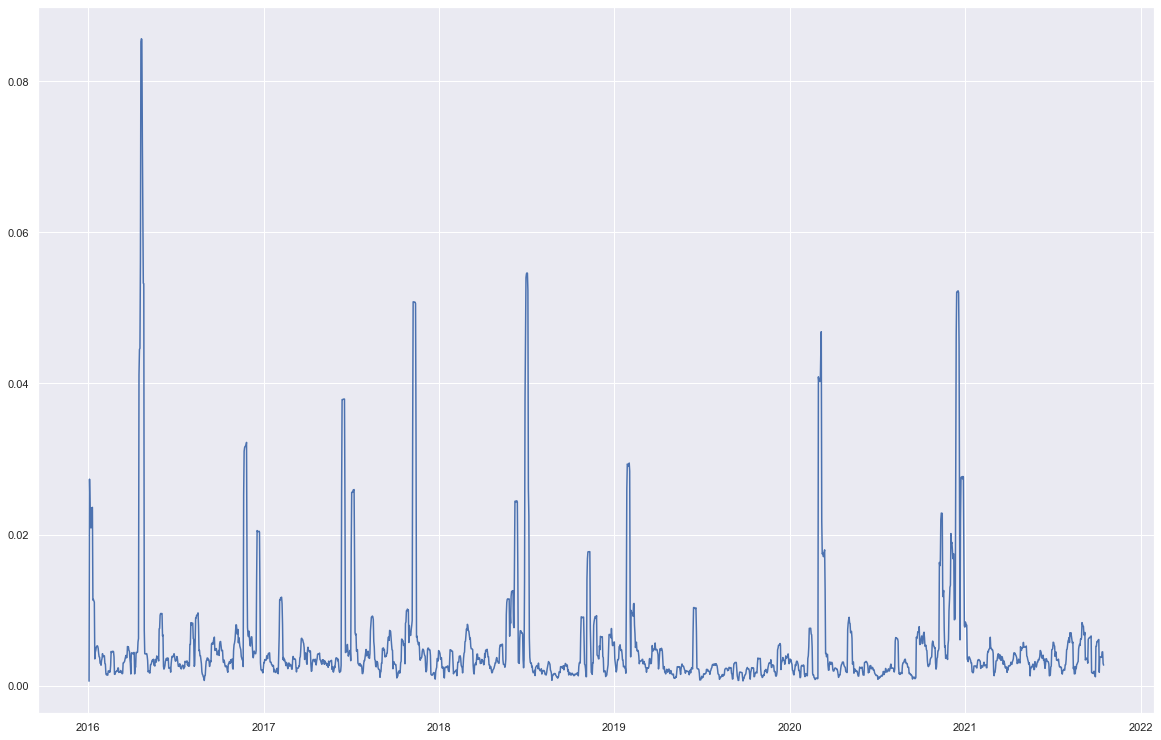

In [70]:
plt.plot(ts_log_moving_avg_diff.rolling(window='7D').std())
plt.show()

In [71]:
#stationary test around mean
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [72]:
kpss_test(ts_log_moving_avg_diff)

Results of KPSS Test:
Test Statistic            0.183924
p-value                   0.100000
Lags Used                55.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\hpp\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<AxesSubplot:xlabel='Date'>

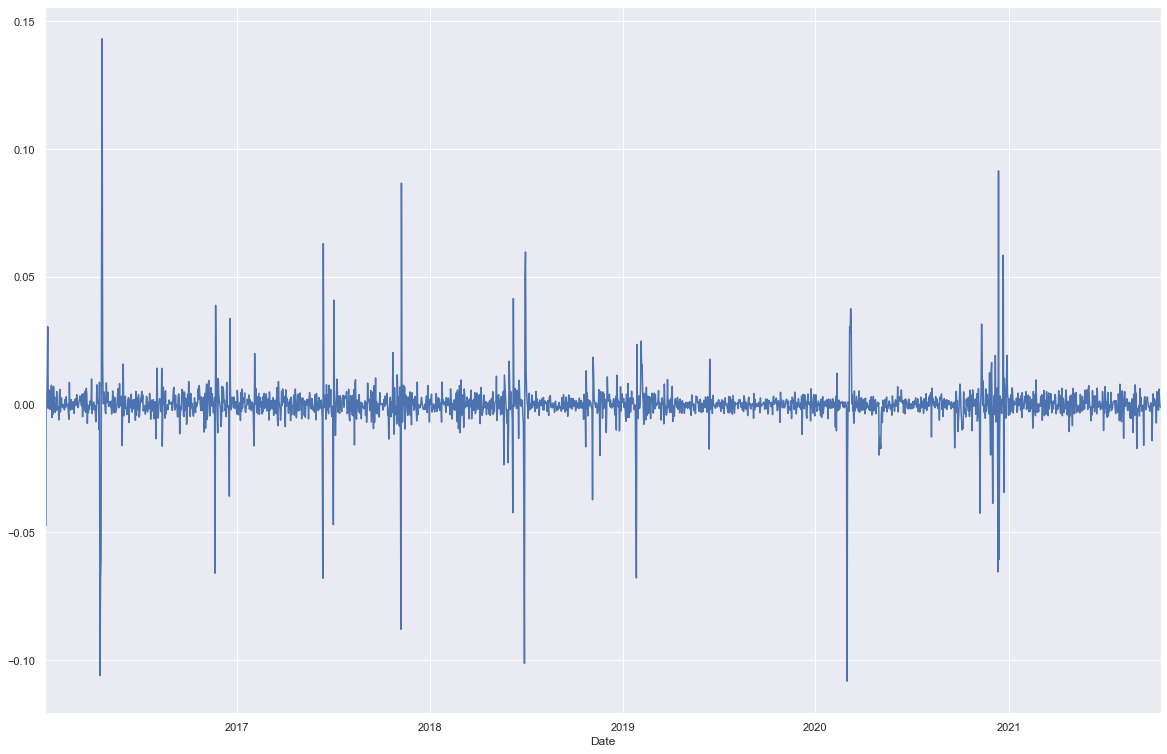

In [73]:
ts_log_moving_avg_diff.plot()

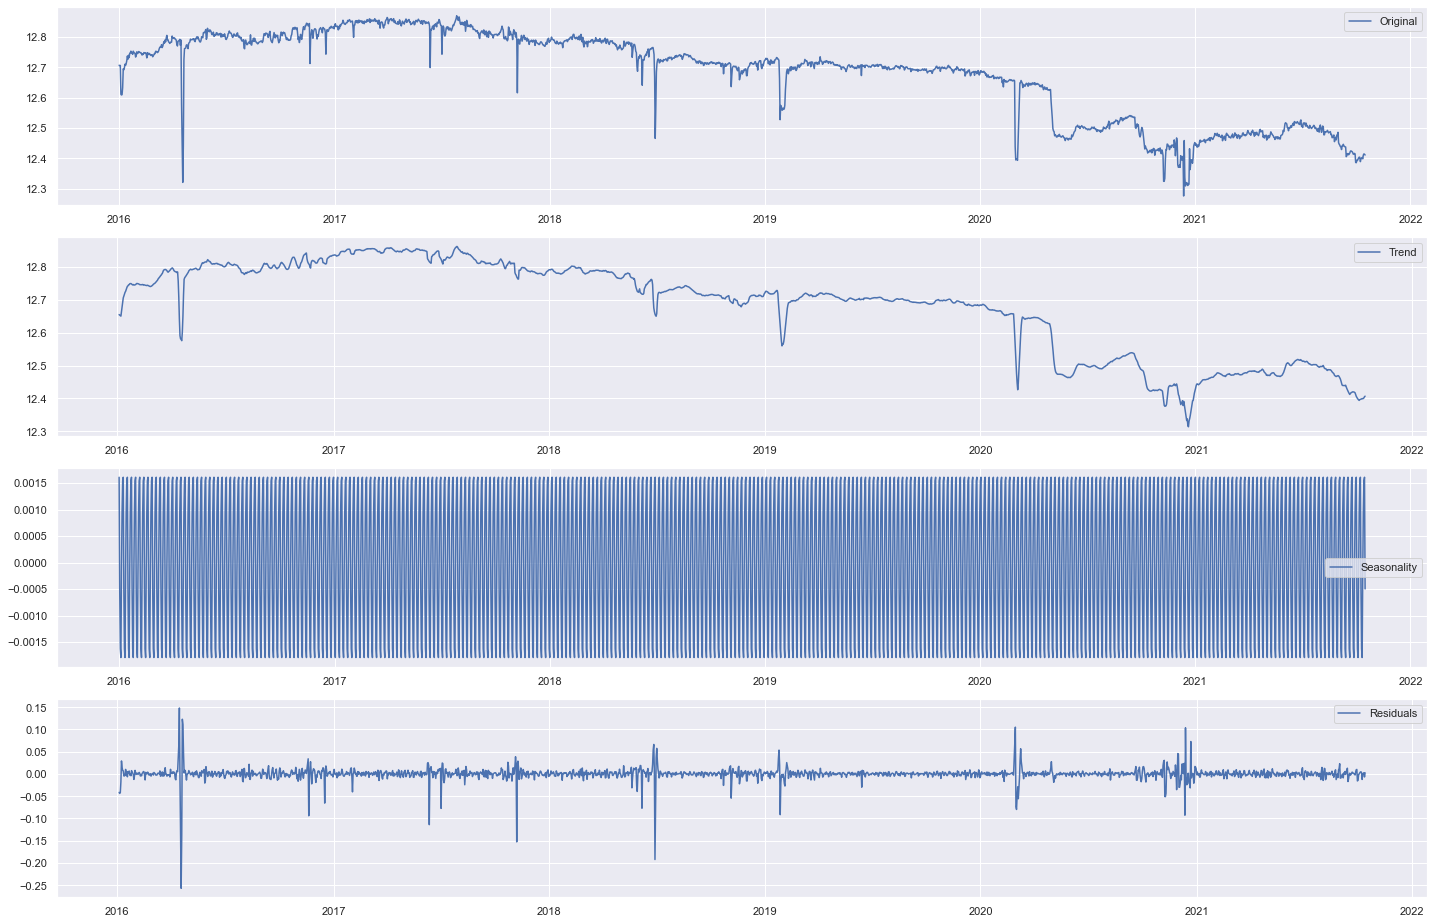

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


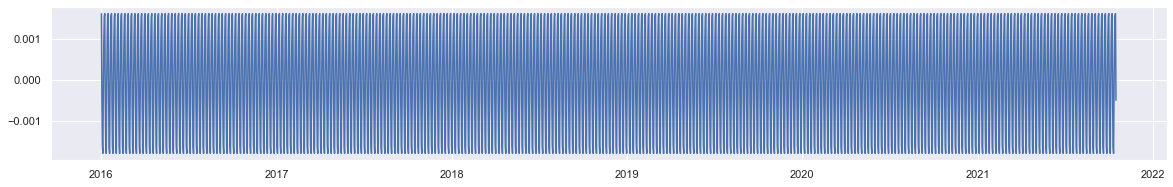

In [75]:
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')



In [76]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

In [77]:
print("Observations of Dickey-fuller test")
dftest = adfuller(ts_log_decompose,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                -1.650747e+01
p-value                        2.120946e-29
#lags used                     2.600000e+01
number of observations used    2.083000e+03
critical value (1%)           -3.433493e+00
critical value (5%)           -2.862929e+00
critical value (10%)          -2.567509e+00
dtype: float64


# ARIMA MODEL

## removing seasonality component as ARIMA does not support it
## seasonal differencing

In [78]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log_diff, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [79]:
y

,DCP
Date,
2016-01-01,329867.0
2016-01-02,329494.0
2016-01-03,329681.0
2016-01-04,299821.0
2016-01-05,299117.0
...,...
2021-10-12,242378.0
2021-10-13,245341.0
2021-10-14,246291.0


In [80]:
ts = y.DCP - y.DCP.shift()
ts.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

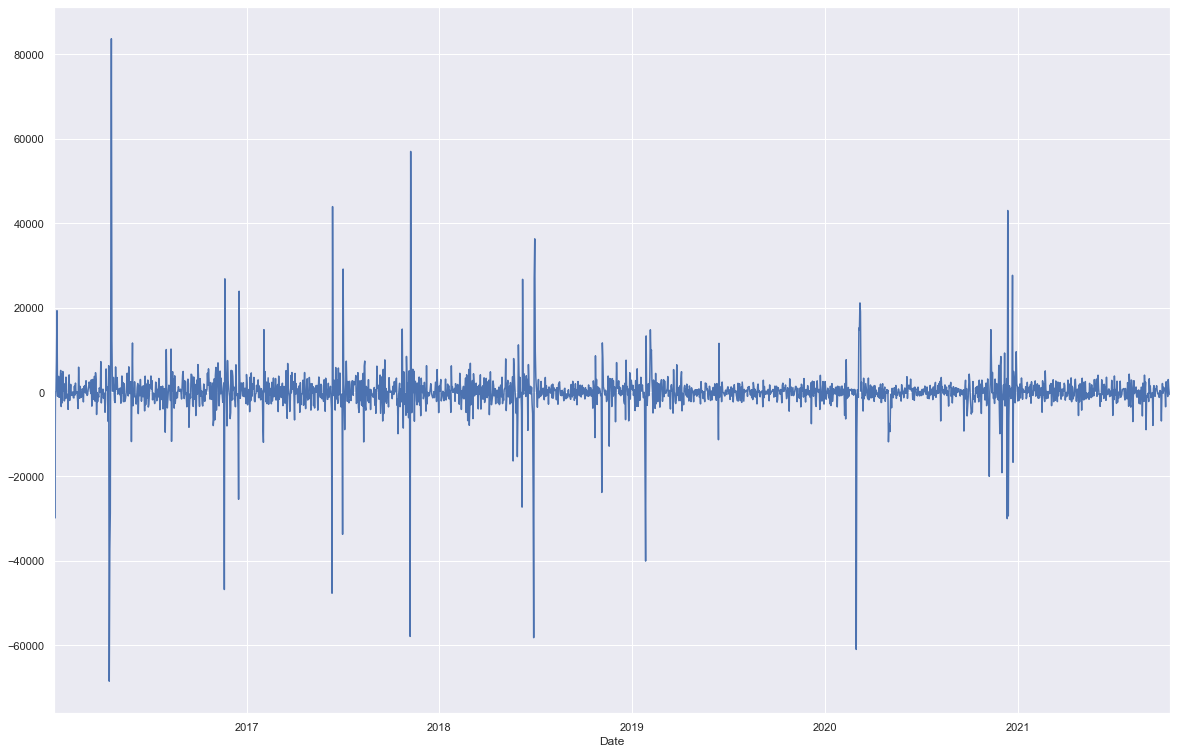

In [81]:
ts.plot()

In [82]:
ts

Date
2016-01-02     -373.0
2016-01-03      187.0
2016-01-04   -29860.0
2016-01-05     -704.0
2016-01-06      284.0
               ...   
2021-10-12    -1057.0
2021-10-13     2963.0
2021-10-14      950.0
2021-10-15     -277.0
2021-10-16     -593.0
Name: DCP, Length: 2115, dtype: float64

In [83]:
ts.describe()

count     2115.000000
mean       -39.927187
std       5716.270880
min     -68492.000000
25%      -1231.000000
50%         12.000000
75%       1340.000000
max      83697.000000
Name: DCP, dtype: float64

<AxesSubplot:xlabel='Date'>

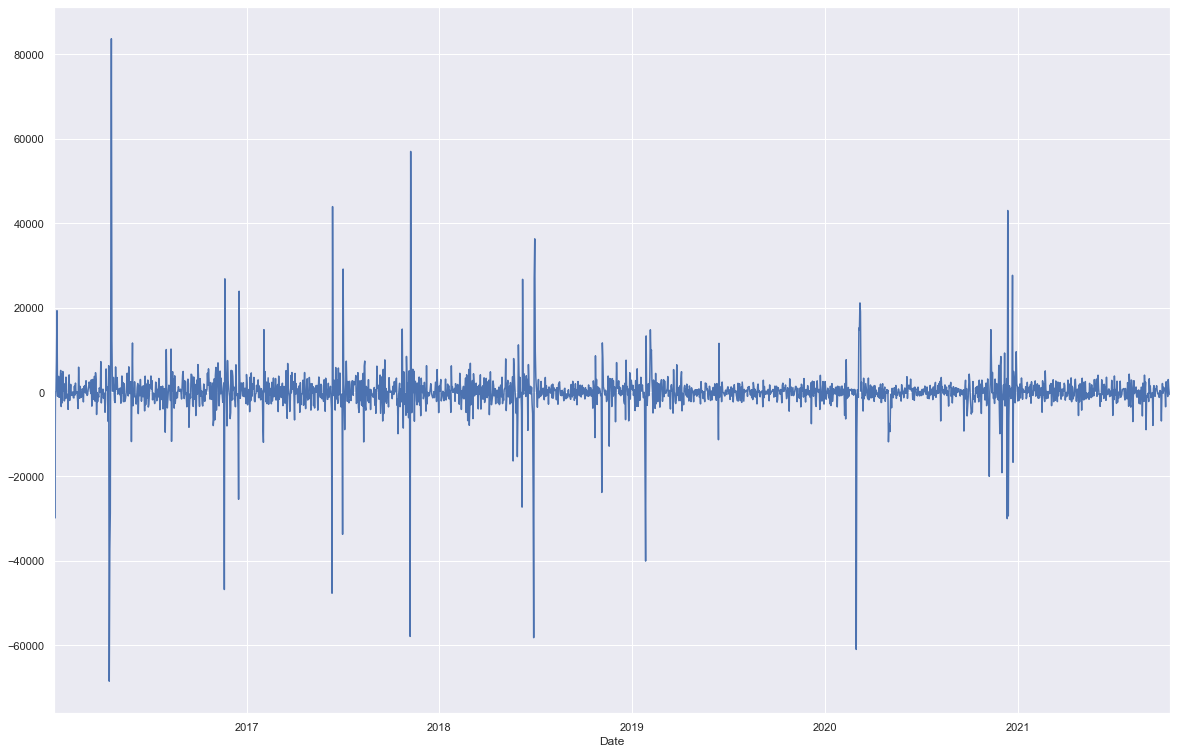

In [84]:
ts.plot()

plt.figure()
plt.subplot(211)
plot_acf(y.DCP, ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(y.DCP, ax=plt.gca(),lags=30)
plt.show()

diff = y.DCP.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

In [139]:
train = y[:int(0.865*(len(y)))]


In [140]:
valid= y[int(0.865*(len(y))):]

<AxesSubplot:xlabel='Date'>

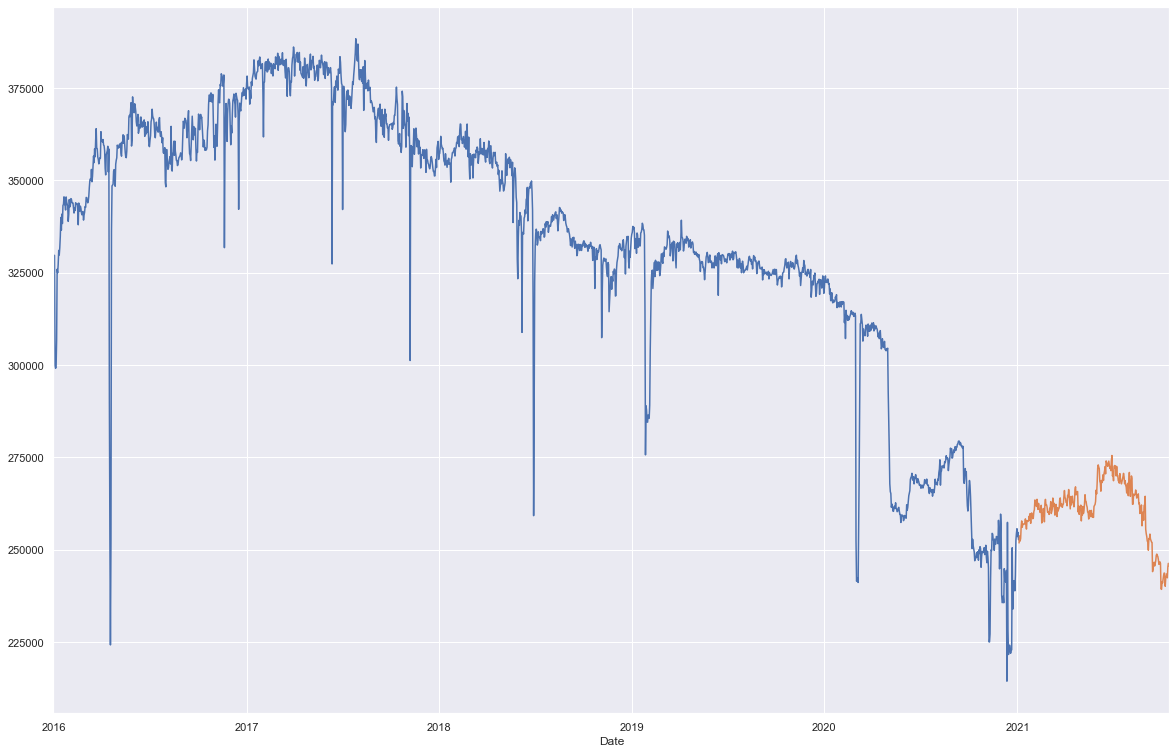

In [141]:
#plotting the data
train['DCP'].plot()
valid['DCP'].plot()

In [142]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [143]:
model = sm.tsa.arima.ARIMA(train, order=(6, 1, 3))
model_fit = model.fit()

C:\Users\hpp\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\hpp\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\hpp\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\hpp\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregr

In [144]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    DCP   No. Observations:                 1830
Model:                 ARIMA(6, 1, 3)   Log Likelihood              -18504.288
Date:                Sun, 14 Nov 2021   AIC                          37028.576
Time:                        12:55:04   BIC                          37083.691
Sample:                    01-01-2016   HQIC                         37048.905
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0234      5.375     -0.004      0.997     -10.558      10.511
ar.L2         -0.0239      4.493     -0.005      0.996      -8.829       8.781
ar.L3         -0.0510      1.749     -0.029      0.977      -3.480       3.378
ar.L4         -0.0486      0.422     -0.115      0.908      -0.875       0.778
ar.L5         -0.0267      0.221     -0.121      0.904      -0.459       0.406
ar.L6         -0.0081      0.058     -0.140      0.888      -0.121       0.105
ma.L1         -0.0188      5.374     -0.003      0.997     -10.551      10.514
ma.L2         -0.0212      4.676     -0.005      0.996      -9.186       9.144
ma.L3         -0.0513      1.810     -0.028      0.977      -3.599       3.497
sigma2      3.478e+07   2.35e-05   1.48e+12      0.000    3.48e+07    3.48e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):            227082.45
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+27. Standard errors may be unstable.
"""

In [145]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [146]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 11191.654908040604, MSE:125253139.58066934


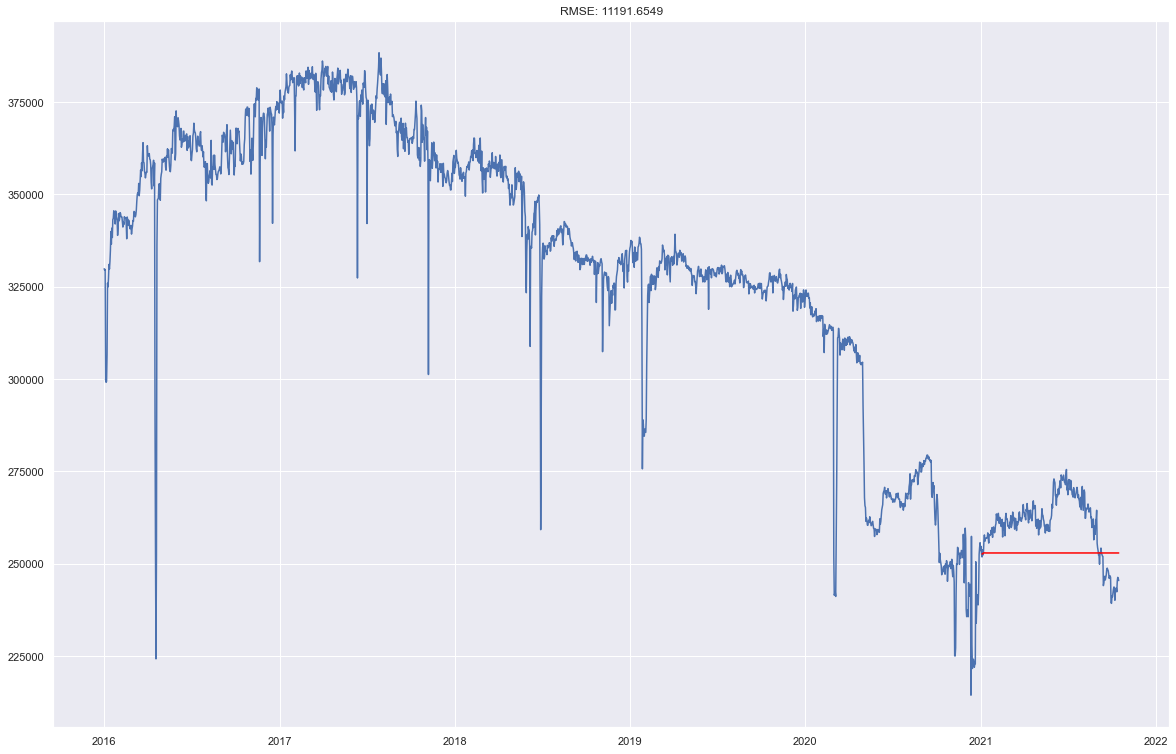

In [147]:
plt.plot(y.DCP)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [151]:
predictions

2021-01-04    252648.972301
2021-01-05    252626.523473
2021-01-06    252796.486587
2021-01-07    252879.058311
2021-01-08    252920.145133
                  ...      
2021-10-12    252899.682373
2021-10-13    252899.682373
2021-10-14    252899.682373
2021-10-15    252899.682373
2021-10-16    252899.682373
Freq: D, Name: predicted_mean, Length: 286, dtype: float64

## seasonal arima

In [101]:
!pip3 install -q pmdarima
from pmdarima.arima import auto_arima
from dateutil.relativedelta import relativedelta

You should consider upgrading via the 'C:\Users\hpp\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [154]:
model = auto_arima(y, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=42547.053, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42599.144, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42598.601, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=42598.641, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42597.247, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=42556.371, Time=0.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=42553.497, Time=0.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=42536.250, Time=2.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=42533.599, Time=0.87 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=42549.698, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=42535.719, Time=1.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=42596.064, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=42539.508, Time=0.33 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=42537.983, Time=1.25 sec
 ARIMA(3,1,1)(0,0,0

In [155]:
model = auto_arima(y,seasonal=True,m=4)

In [156]:
model

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True, with_intercept=False)

In [157]:
date = y.index[-1]
last_val = y.iloc[-1].to_numpy()

In [158]:
date

Timestamp('2021-10-16 00:00:00')

In [159]:
forecasts=5
date_store = [(date + relativedelta(days=i)) for i in range(0,forecasts+1)]

predict = model.predict(forecasts)
predict =  np.append(last_val,predict)
forecast_df = pd.DataFrame(data=predict,index=date_store,columns=['DCP'])
forecast_df

,DCP
2021-10-16,245421.000000
2021-10-17,245208.378366
2021-10-18,245139.634474
2021-10-19,245158.169026
2021-10-20,245185.892420
2021-10-21,245204.606253


In [160]:
y.describe()

,DCP
count,2116.000000
mean,324836.804820
std,42792.314072
min,214386.000000
25%,277484.000000
50%,331924.000000
75%,359316.250000
max,388370.000000


In [161]:
y.tail()

,DCP
Date,
2021-10-12,242378.0
2021-10-13,245341.0
2021-10-14,246291.0
2021-10-15,246014.0
2021-10-16,245421.0


<AxesSubplot:>

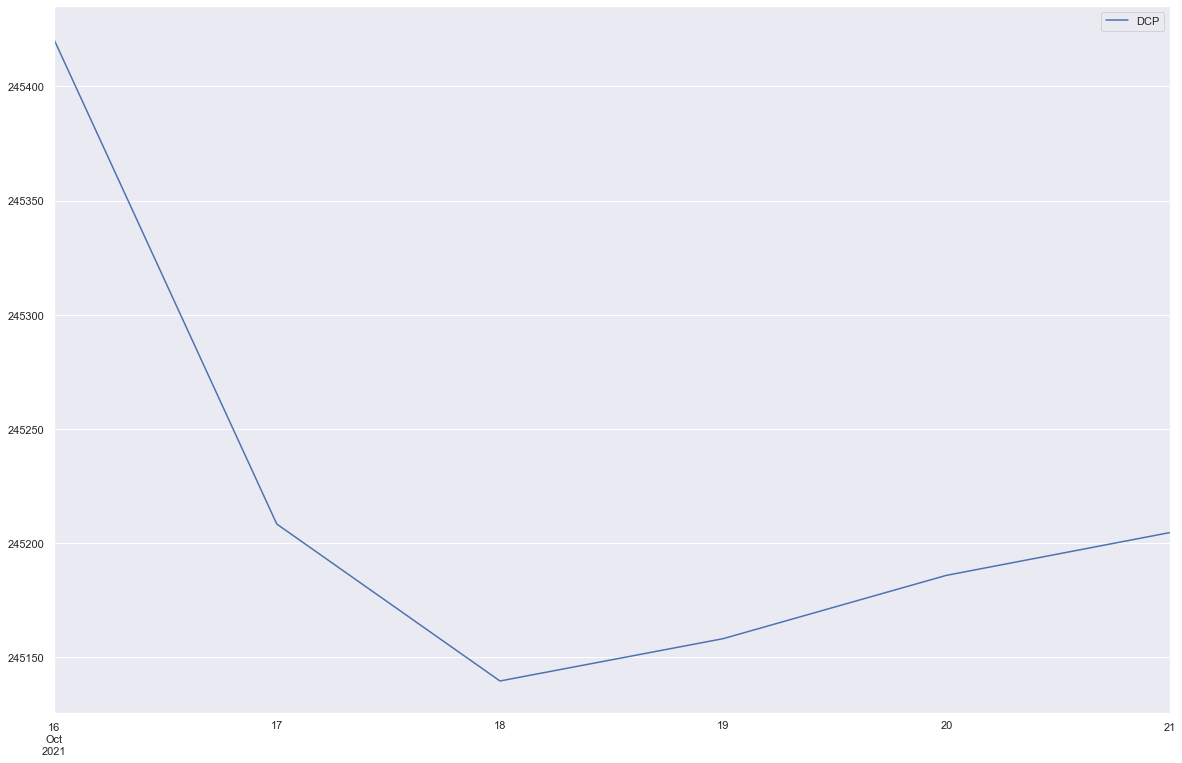

In [164]:
forecast_df.plot()

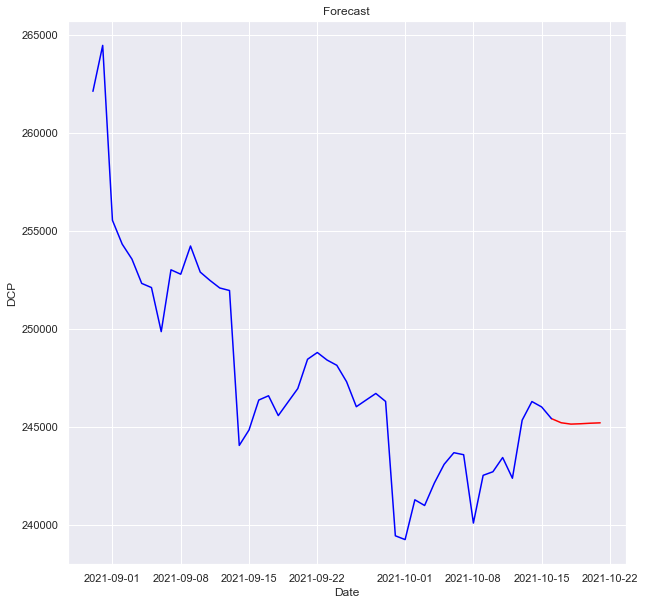

In [165]:
_,ax=plt.subplots(1,1,figsize=(10,10))
sns.lineplot(data=forecast_df['DCP'],ax=ax,color='red')
sns.lineplot(data=y['DCP'][-4*12:],ax=ax,color='blue')
_=plt.title(f'Forecast')